## Modelling employee attrition

### Process:

- We are working with cleaned data
- Split into Train / Valid / Test datasets.
- 

In [1]:
import os
import sys
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost
import mlflow
import warnings

from sklearn.preprocessing import LabelEncoder, OneHotEncoder


In [2]:
import matplotlib as mpl
mpl.rcParams['font.family'] = 'sans-serif'

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
# Add my parent directory to path variables
current_location = Path(os.path.abspath('')).parent.resolve()
print(current_location)
sys.path.append(str(current_location))

/Users/ryanmccarlie/Documents/Problems/PwC Interview/Code


In [5]:
data_dir = os.path.join(current_location, "data")

raw_data_dir = os.path.join(data_dir, "raw_data")
os.makedirs(raw_data_dir, exist_ok=True)

transformed_data_dir = os.path.join(data_dir, "transformed_data")
os.makedirs(transformed_data_dir, exist_ok=True)

output_data_dir = os.path.join(data_dir, "output_data")
os.makedirs(output_data_dir, exist_ok=True)

processed_dir = os.path.join(data_dir, "processed_dir")
os.makedirs(processed_dir, exist_ok=True)

models_dir = os.path.join(data_dir, "models")
os.makedirs(models_dir, exist_ok=True)

# report_dir = os.path.join(data_dir, "reports")
# os.makedirs(report_dir, exist_ok=True)

In [6]:
random_state_var = 42
random_state_var

42

## Read in transformed data

In [7]:
# Load data
from utils.train import load_train_valid_data


X_train, y_train, X_valid, y_valid = load_train_valid_data(
    target="target", 
    transformed_data_dir=transformed_data_dir,
)

/Users/ryanmccarlie/Documents/Problems/PwC Interview/Code/notebooks


In [8]:
# cleaned_fname = os.path.join(transformed_data_dir, "cleaned_non_scaled_17_09_2024.csv")
# modelling_data = pd.read_csv(cleaned_fname)

# modelling_data = modelling_data.drop(columns=["Attrition"], errors="ignore")

# # print(modelling_data.columns)
# print(modelling_data.shape)
# modelling_data.head(3)

## Train Test Split

In [9]:
target_col = "target"

In [10]:
X_train.head(2)

,Age,YearsAtCompany,MonthlyIncome,DistanceFromHome,JobLevel,PercentSalaryHike,PerformanceRating,JobSatisfaction,PercentOfYearsInCurrentRole,YearsSincePromoOverTotalYearsRatio,...,SatisfactionToDepartmentAvg_greater,SatisfactionToDepartmentAvg_less,DistanceGroup_Close,DistanceGroup_Moderate,DistanceGroup_Far,DistanceGroup_Very Far,AgeGroup_Under 30,AgeGroup_30-40,AgeGroup_40-50,AgeGroup_50+
0,61.0,1.0,14097.0,46.0,2.0,5.0,1.0,2.0,1.000000,0.000000,...,False,True,False,False,False,True,False,False,False,True
1,60.0,13.0,3672.0,46.0,5.0,18.0,3.0,4.0,0.384615,0.153846,...,False,False,False,False,False,True,False,False,False,True


In [11]:
y_train.head()

0    1
1    0
2    0
3    1
4    1
Name: target, dtype: int64

In [12]:
from xgboost import XGBClassifier

from sklearn.preprocessing import FunctionTransformer
from sklearn.metrics import accuracy_score, balanced_accuracy_score, classification_report, f1_score, roc_auc_score, confusion_matrix
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
from hyperopt.pyll import scope
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer


In [13]:
from scripts.model_training import create_pipeline


model_name = "XGBoost" # Options: [XGBoost, DecisionTree, RandomForrest]
pipeline = create_pipeline(X_train, model_name)
pipeline

/Users/ryanmccarlie/Documents/Problems/PwC Interview/Code/notebooks
/Users/ryanmccarlie/Documents/Problems/PwC Interview/Code/notebooks
/Users/ryanmccarlie/Documents/Problems/PwC Interview/Code/notebooks


/Users/ryanmccarlie/.pyenv/versions/3.11.6/envs/PwC-Attrition-model-3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['Age', 'YearsAtCompany',
                                                   'MonthlyIncome',
                                                   'DistanceFromHome',
                                                   'JobLevel',
                                                   'PercentSalaryHike',
                                                   'PerformanceRating',
                                                   'JobSatisfaction',
                                                   'PercentOfYearsInCurrentRole',
                                                   'YearsSincePromoOverTotalYearsRatio',
                                                   'SalaryHikeToIncome',
                                                   'DeptOvertimeRati...
                               feature_types=None, gamma=2, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=42, ...))])

In [14]:
# Identify numeric and categorical columns
bool_features = X_train.select_dtypes(include=['bool']).columns
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X_train.select_dtypes(include=['object', 'category']).columns

assert len(bool_features) + len(numeric_features) + len(categorical_features) == X_train.shape[1]


In [15]:
from scripts.model_training import define_hyperparam_space

model_name = "XGBoost" # Options: [XGBoost, DecisionTree, RandomForrest]
space = define_hyperparam_space(model_name)
space


{'classifier__n_estimators': <hyperopt.pyll.base.Apply at 0x15f6df390>,
 'classifier__max_depth': <hyperopt.pyll.base.Apply at 0x15f6df750>,
 'classifier__learning_rate': <hyperopt.pyll.base.Apply at 0x15f6dfb10>,
 'classifier__colsample_bytree': <hyperopt.pyll.base.Apply at 0x15f6dfed0>,
 'classifier__colsample_bylevel': <hyperopt.pyll.base.Apply at 0x15f6ec2d0>,
 'classifier__min_child_weight': <hyperopt.pyll.base.Apply at 0x15f6ec690>}

In [16]:
# Hyperparameter tuning
from scripts.model_training import tune_hyperparameters


pipeline, best_params = tune_hyperparameters(
    pipeline=pipeline, 
    space=space,
    X_train=X_train, y_train=y_train, X_valid=X_valid, y_valid=y_valid, 
    n_trials=10
)

print(f"best_params: {best_params}")

100%|██████████| 10/10 [00:00<00:00, 16.20trial/s, best loss: -0.5370885543915895]
best_params: {'classifier__colsample_bylevel': np.float64(0.4838860954865496), 'classifier__colsample_bytree': np.float64(0.40328176532059745), 'classifier__learning_rate': np.float64(0.22693037415851622), 'classifier__max_depth': np.int64(15), 'classifier__min_child_weight': np.int64(7), 'classifier__n_estimators': np.int64(148)}


In [17]:
pipeline.fit(X_train, y_train)
print("Pipeline fitted on only training data.")

Pipeline fitted on only training data.


In [18]:
all_params = pipeline.named_steps['classifier'].get_params()
all_params

{'objective': 'binary:logistic',
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': np.float64(0.4838860954865496),
 'colsample_bynode': None,
 'colsample_bytree': np.float64(0.40328176532059745),
 'device': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': 'logloss',
 'feature_types': None,
 'gamma': 2,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': np.float64(0.22693037415851622),
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': np.int64(15),
 'max_leaves': None,
 'min_child_weight': np.int64(7),
 'missing': nan,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_estimators': np.int64(148),
 'n_jobs': None,
 'num_parallel_tree': None,
 'random_state': 42,
 'reg_alpha': 1.5,
 'reg_lambda': 3.0,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate

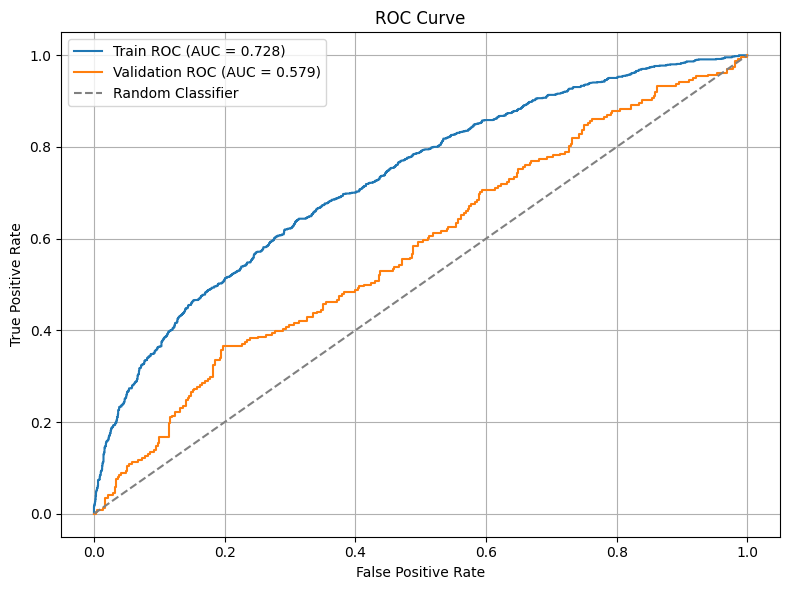

In [19]:
from scripts.model_training import plot_roc_curve


plot_roc_curve(
    model=pipeline, 
    X_train=X_train, y_train=y_train, X_valid=X_valid, y_valid=y_valid,
    save_path=None,
    show_plot=True
)
plt.show()

In [20]:
# Evaluate performance on test set
from scripts.model_training import run_evaluation_with_plots


classifier_metrics = run_evaluation_with_plots(
    model=pipeline,
    X_test=X_valid,
    y_test=y_valid,
    metrics_dir=None,
    evaluation_dir=None,
)
validation_metrics = classifier_metrics.get_metrics_dict()
validation_metrics

{'f1_score': np.float64(0.6103431115960514),
 'accuracy': 0.6240369799691834,
 'balanced_accuracy': np.float64(0.5696344231123106),
 'precision': np.float64(0.6066365289992913),
 'recall': np.float64(0.6240369799691834),
 'roc_auc': np.float64(0.5791572103293873)}

In [21]:
X_valid_out["pred"].value_counts()

NameError: name 'X_valid_out' is not defined

In [29]:
print(classification_report(y_valid, y_valid_pred_attrition))


              precision    recall  f1-score   support

           0       0.64      0.86      0.74       411
           1       0.43      0.18      0.26       238

    accuracy                           0.61       649
   macro avg       0.54      0.52      0.50       649
weighted avg       0.56      0.61      0.56       649



In [30]:
assert len(pipeline.named_steps['classifier'].feature_importances_) == len(X_train.columns) 


In [30]:

def plot_feature_importance(pipeline, feature_names, top_n=20, show_plots=False):
    # Extract feature importances
    importances = pipeline.named_steps['classifier'].feature_importances_
    feature_importance = pd.Series(importances, index=feature_names)
    top_features = feature_importance.sort_values(ascending=False).head(top_n)
    
    # Plot
    plt.figure(figsize=(10,8))
    sns.barplot(x=top_features.values, y=top_features.index)
    plt.title('Top Feature Importances')
    plt.xlabel('Importance Score')
    plt.ylabel('Features')
    plt.tight_layout()
    plt.show()

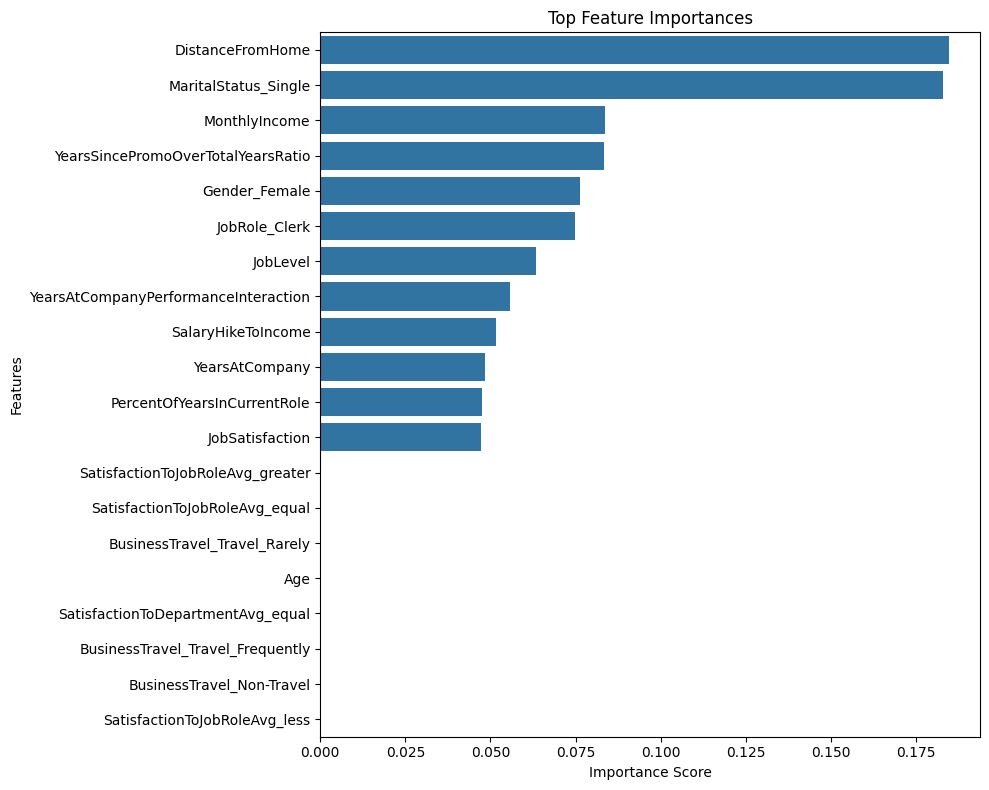

In [40]:
# from utils.visualisation import plot_feature_importance

plot_feature_importance(pipeline, X_valid.columns, top_n=20)

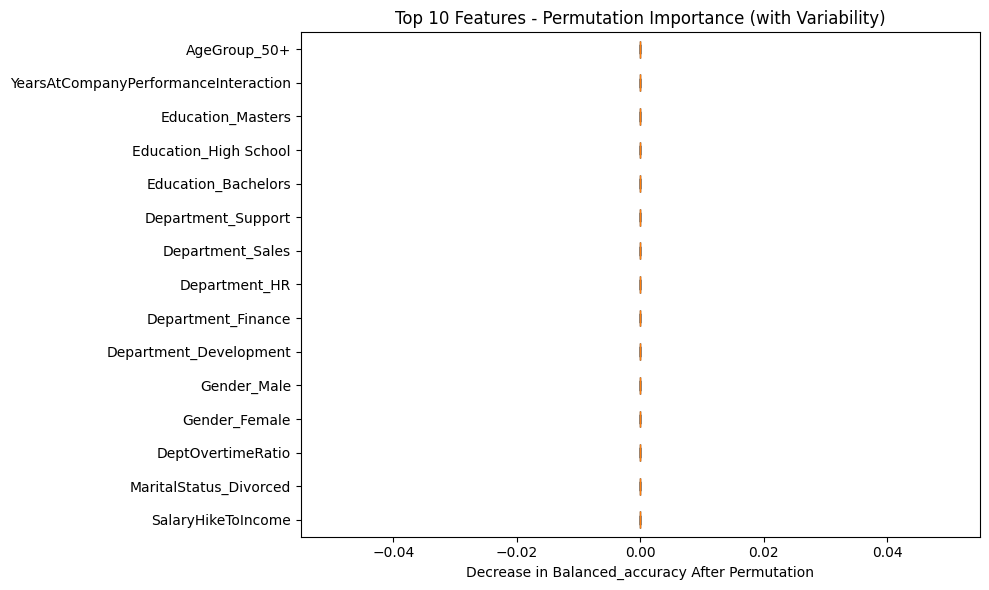

In [43]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance

# Assuming 'loaded_pipeline' is your pipeline and X_test, y_test are the test set
# Compute permutation importance
scoring_name = 'balanced_accuracy' # Options: ["accuracy", "balanced_accuracy", "f1_weighted", "f1"]
result = permutation_importance(
    pipeline, X_valid, y_valid,
    n_repeats=30,  # Number of shuffling runs
    random_state=42, 
    scoring=scoring_name,
)

top_n_features = 15
show_box_plot = True
if show_box_plot:
    # Extract feature names and permutation importance values
    feature_names = X_valid.columns if hasattr(X_valid, 'columns') else np.arange(X_valid.shape[1])
    importances = result.importances  # This gives all the permutation importance values for each feature

    # Sort features by mean importance and select the top_n_features
    sorted_indices = np.argsort(result.importances_mean)[-top_n_features:]

    # Plot the box plot for the  top_n_features features
    plt.figure(figsize=(10, 6))
    plt.boxplot([importances[i] for i in sorted_indices], vert=False, patch_artist=True)
    plt.yticks(range(1, len(sorted_indices) + 1), [feature_names[i] for i in sorted_indices])
    plt.xlabel(f'Decrease in {scoring_name.capitalize()} After Permutation')
    plt.title('Top 10 Features - Permutation Importance (with Variability)')
    plt.tight_layout()

    # Show the plot
    plt.show()
else:

    # Extract feature names, mean importance, and standard deviation
    feature_names = X_valid.columns if hasattr(X_valid, 'columns') else np.arange(X_valid.shape[1])
    importances = result.importances_mean
    std = result.importances_std

    # Sort features by importance and select the top_n_features
    indices = np.argsort(importances)[-top_n_features:]  # Get the indices of the top_n_features

    # Plot the top_n_features importance as a horizontal bar chart
    plt.figure(figsize=(10, 6))
    plt.barh(range(len(indices)), importances[indices], xerr=std[indices], align='center', alpha=0.8)
    plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
    plt.xlabel('Mean Permutation Importance (with Std)')
    plt.title('Top 10 Features - Permutation Importance with Variability')
    plt.tight_layout()

    # Show the plot
    plt.show()


In [ ]:
assert False

In [71]:
# # Save pipeline model
# import pickle

# # Save the pipeline with pickle
# model_out_fname = os.path.join(models_dir, "model_pipeline.pkl")
# with open(model_out_fname, 'wb') as f:
#     pickle.dump(pipeline, f)

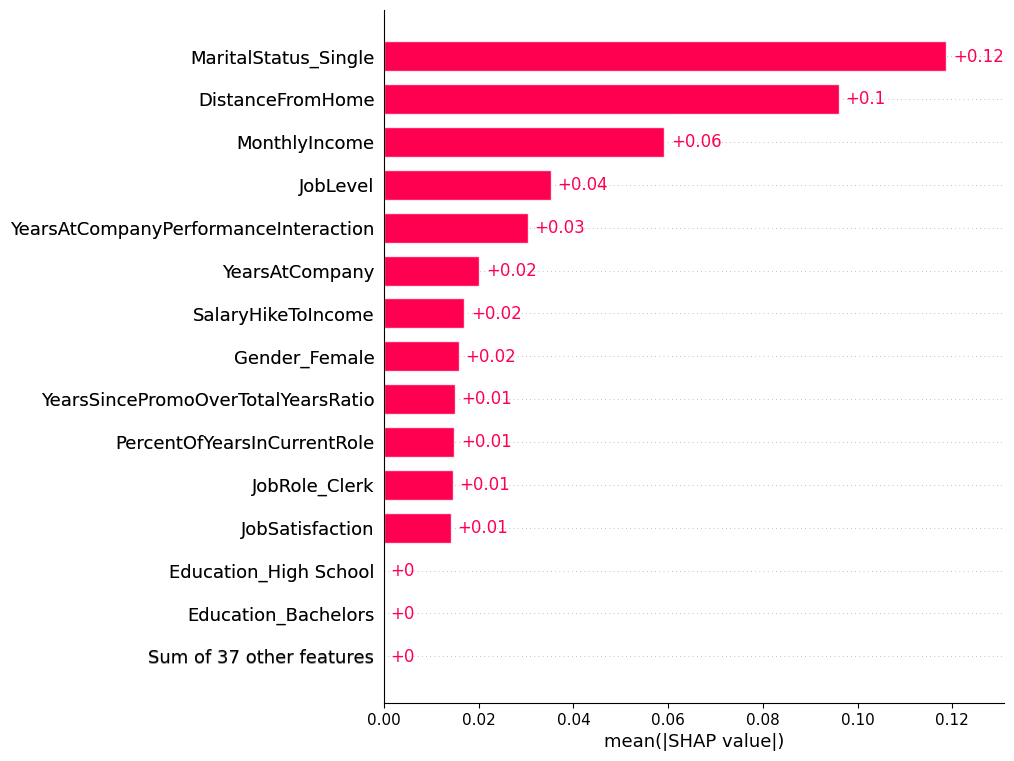

In [42]:
import shap

# Assuming 'loaded_pipeline' is your pipeline
# Extract the model from the pipeline
xgb_model = pipeline.named_steps['classifier']

# Preprocess the data using the 'preprocessor' step of the pipeline
preprocessed_data = pipeline.named_steps['preprocessor'].transform(X_valid)
preprocessed_data_df = pd.DataFrame(data=preprocessed_data, columns=X_valid.columns)

# Create a SHAP explainer for the XGBoost model
explainer = shap.Explainer(xgb_model)
shap_values = explainer(preprocessed_data_df)

shap.plots.bar(shap_values, max_display=15)

# Plot the SHAP summary plot
# shap.summary_plot(shap_values, preprocessed_data_df)
# Plot the feature importance as a bar chart
# shap.plots.bar(shap_values)


# If running in a script or notebook, you may need to explicitly show the plot
plt.show()

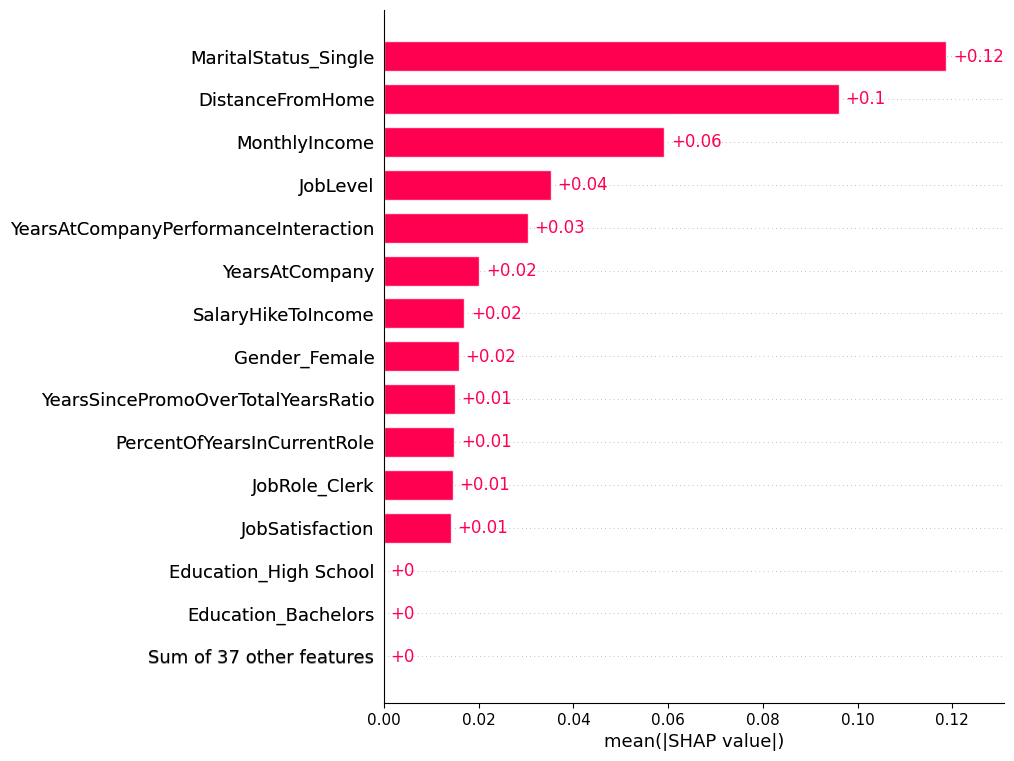

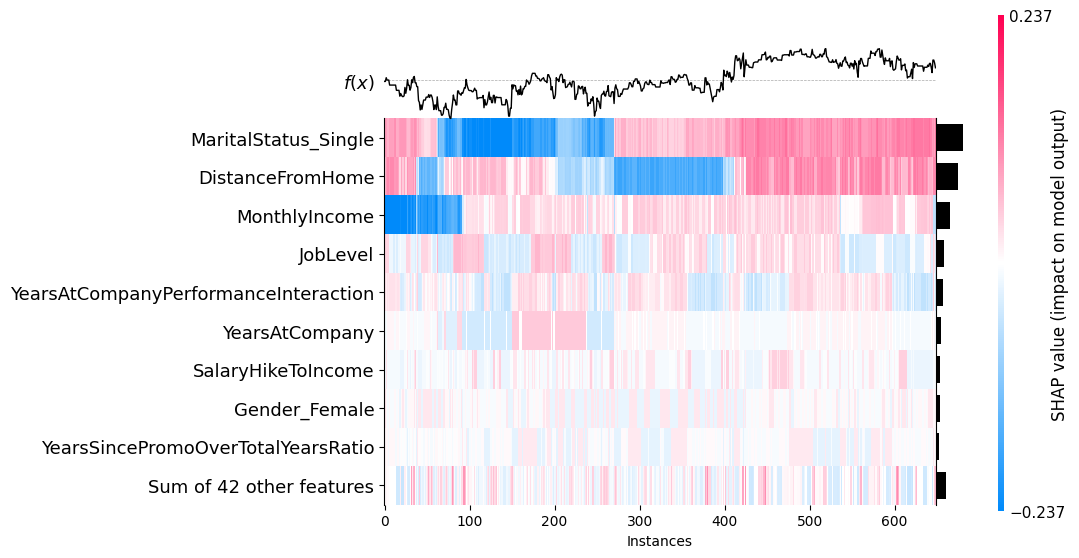

<Axes: xlabel='Instances'>

In [38]:
shap.plots.heatmap(shap_values)

In [55]:

def evaluate_model(model, X, y, model_name="Model", dataset_name="validation"):
    # Predictions
    y_pred = model.predict(X)
    y_proba = model.predict_proba(X)[:,1]
    
    # Evaluation Metrics
    report = classification_report(y, y_pred, output_dict=True)
    roc_auc = roc_auc_score(y, y_proba)
    conf_matrix = confusion_matrix(y, y_pred)
    
    # Log metrics
    print("roc_auc", roc_auc)
    print({
        "precision": report['1']['precision'],
        "recall": report['1']['recall'],
        "f1_score": report['1']['f1-score']
    })
    
    # Log confusion matrix as an artifact
    conf_matrix_df = pd.DataFrame(conf_matrix, index=['Actual 0', 'Actual 1'], columns=['Predicted 0', 'Predicted 1'])
    display(conf_matrix_df)
    
    # Save evaluation metrics
    eval_metrics = {
        'classification_report': report,
        'roc_auc_score': roc_auc,
        'confusion_matrix': conf_matrix.tolist()
    }
    return eval_metrics

In [56]:
# Set the maximum number of rows to display
pd.set_option('display.max_rows', 5)



In [58]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import mlflow
from sklearn.metrics import roc_auc_score, classification_report

    


In [64]:
# def prepare_dashboard_data(model_name, model, X, y):
#     # Feature Importance
#     fi_png_path = os.path.join(report_dir, f"feature_importance_{model_name.lower()}.png")
#     plot_feature_importance(model, X.columns, top_n=20, save_path=fi_png_path)
    
#     # SHAP Summary Plot
#     # shap_explain(model, X, save_path=f'{save_path_prefix}shap_summary_{model_name.lower()}.png')
    
#     # Prepare dashboard metrics
#     importances = model.named_steps['classifier'].feature_importances_
#     feature_names = X.columns
#     feature_importance_df = pd.DataFrame({
#         'Feature': feature_names,
#         'Importance': importances
#     }).sort_values(by='Importance', ascending=False)
    
#     # Model performance metrics
#     y_proba = model.predict_proba(X)[:,1]
#     roc_auc = roc_auc_score(y, y_proba)
#     report = classification_report(y, model.predict(X), output_dict=True)
    
#     # Save feature importance
#     feat_imp_out = os.path.join(report_dir, f"dashboard_feature_importance_{model_name.lower()}.csv")
#     feature_importance_df.to_csv(feat_imp_out, index=False)
    
#     # Save metrics
#     metrics = {
#         'Model': model_name,
#         'ROC_AUC': roc_auc,
#         'Precision': report['1']['precision'],
#         'Recall': report['1']['recall'],
#         'F1_Score': report['1']['f1-score']
#     }
#     metrics_df = pd.DataFrame([metrics])
#     dm_csv_path = os.path.join(report_dir, f"dashboard_metrics_{model_name.lower()}.csv")
#     metrics_df.to_csv(dm_csv_path, index=False)
    
#     return feature_importance_df, metrics_df

In [101]:
# feature_importance_df, metrics_df = prepare_dashboard_data(model_name, best_model, X_test, y_test)

In [ ]:
# for model, metrics in evaluation_results.items():
#     break

# metrics

In [78]:
# # Save all evaluation metrics to a JSON file
# import json
# json_out = os.path.join(report_dir, 'evaluation_metrics.json')
# with open(json_out, 'w') as f:
#     json.dump(evaluation_results, f, indent=4)
# # mlflow.log_artifact('reports/evaluation_metrics.json')

# # Optionally, save a summary report
# summary_df = pd.DataFrame([
#     {
#         'Model': model,
#         'ROC_AUC': metrics['roc_auc_score'],
#         'Precision': metrics['classification_report']['0']['precision'],
#         'Recall': metrics['classification_report']['0']['recall'],
#         'F1_Score': metrics['classification_report']['0']['f1-score']
#     } for model, metrics in evaluation_results.items()
# ])
# summ_fname = os.path.join(report_dir, "model_comparison.csv")
# summary_df.to_csv(summ_fname, index=False)

# # mlflow.log_artifact('reports/model_comparison.csv')

# # Print evaluation scores for test set
# print("\n=== Model Evaluation on Test Set ===")
# for model, metrics in evaluation_results.items():
#     print(f"\nModel: {model}")
#     print(f"ROC AUC Score: {metrics['roc_auc_score']:.4f}")
#     print("Classification Report:")
#     print(pd.DataFrame(metrics['classification_report']).transpose())
#     print("Confusion Matrix:")
#     print(pd.DataFrame(metrics['confusion_matrix'], 
#                         index=['Actual 0', 'Actual 1'], 
#                         columns=['Predicted 0', 'Predicted 1']))

# print("\nAll models have been trained, evaluated, and logged to MLflow.")


=== Model Evaluation on Test Set ===

Model: XGBoost
ROC AUC Score: 0.6181
Classification Report:
              precision    recall  f1-score     support
0              0.633694  1.000000  0.775781  410.000000
1              0.000000  0.000000  0.000000  237.000000
accuracy       0.633694  0.633694  0.633694    0.633694
macro avg      0.316847  0.500000  0.387890  647.000000
weighted avg   0.401568  0.633694  0.491607  647.000000
Confusion Matrix:
          Predicted 0  Predicted 1
Actual 0          410            0
Actual 1          237            0

Model: RandomForest
ROC AUC Score: 0.5767
Classification Report:
              precision    recall  f1-score     support
0              0.656250  0.870732  0.748428  410.000000
1              0.485437  0.210970  0.294118  237.000000
accuracy       0.629057  0.629057  0.629057    0.629057
macro avg      0.570843  0.540851  0.521273  647.000000
weighted avg   0.593680  0.629057  0.582011  647.000000
Confusion Matrix:
          Predicted 0 

## Generate Dashboard

In [ ]:
# # src/mlflow_integration.py
# import mlflow
# from src.data_preprocessing import split_and_save_data
# from src.model import train_model
# from src.evaluate_model import evaluate_model
# from src.visualize import plot_feature_importance, shap_explain
# import pandas as pd
# import joblib


# # Start a top-level MLflow run
# with mlflow.start_run(run_name="Employee Attrition Pipeline") as run:
#     # Data Splitting
#     data_splits = split_and_save_data()
#     X_train = data_splits['X_train']
#     y_train = data_splits['y_train']
#     X_valid = data_splits['X_valid']
#     y_valid = data_splits['y_valid']
#     X_test = data_splits['X_test']
#     y_test = data_splits['y_test']
    
#     # Define preprocessing pipeline
#     from sklearn.pipeline import Pipeline
#     from sklearn.impute import SimpleImputer
    
#     preprocessing = Pipeline(steps=[
#         ('imputer', SimpleImputer(strategy='median'))
#     ])
    
#     # Define hyperparameter grid
#     param_distributions = {
#         'classifier__n_estimators': [100, 200, 300, 400, 500],
#         'classifier__max_depth': [None, 10, 20, 30, 40, 50],
#         'classifier__min_samples_split': [2, 5, 10],
#         'classifier__min_samples_leaf': [1, 2, 4],
#         'classifier__max_features': ['auto', 'sqrt', 'log2']
#     }
    
#     # Train the model with hyperparameter tuning
#     best_search = train_model(
#         X_train, y_train, preprocessing, param_distributions
#     )
    
#     # Retrieve the best model
#     best_model = best_search.best_estimator_
    
#     # Log the model as an artifact in the top-level run
#     mlflow.sklearn.log_model(best_model, "best_model_pipeline")
    
#     # Evaluate on validation set
#     eval_metrics_valid = evaluate_model(best_model, X_valid, y_valid, dataset_name="validation")
    
#     # Evaluate on test set
#     eval_metrics_test = evaluate_model(best_model, X_test, y_test, dataset_name="test")
    
#     # Feature Importance
#     plot_feature_importance(best_model, X_train.columns, save_path='reports/feature_importance.png')
    
#     # SHAP Summary Plot
#     # shap_explain(best_model, X_valid, save_path='reports/shap_summary.png')
    
#     # Log evaluation metrics as artifacts
#     import json
#     with open('reports/evaluation_metrics.json', 'w') as f:
#         json.dump({
#             'validation': eval_metrics_valid,
#             'test': eval_metrics_test
#         }, f, indent=4)
#     mlflow.log_artifact('reports/evaluation_metrics.json')
    
#     # Log feature importance and SHAP plots as artifacts
#     mlflow.log_artifact('reports/feature_importance.png')
#     mlflow.log_artifact('reports/shap_summary.png')
    
#     # Save Dashboard Data
#     def prepare_dashboard_data(model, X, y, save_path='reports/dashboard_metrics.csv'):
#         importances = model.named_steps['classifier'].feature_importances_
#         feature_names = X.columns
#         feature_importance = pd.DataFrame({
#             'Feature': feature_names,
#             'Importance': importances
#         }).sort_values(by='Importance', ascending=False)
        
#         # Add model performance metrics
#         from sklearn.metrics import roc_auc_score, classification_report
#         y_proba = model.predict_proba(X)[:,1]
#         roc_auc = roc_auc_score(y, y_proba)
#         report = classification_report(y, model.predict(X), output_dict=True)
        
#         # Save feature importance
#         feature_importance.to_csv('reports/dashboard_feature_importance.csv', index=False)
#         mlflow.log_artifact('reports/dashboard_feature_importance.csv')
        
#         # Save metrics
#         metrics = {
#             'ROC_AUC': roc_auc,
#             'Precision': report['1']['precision'],
#             'Recall': report['1']['recall'],
#             'F1_Score': report['1']['f1-score']
#         }
#         pd.DataFrame([metrics]).to_csv(save_path, index=False)
#         mlflow.log_artifact(save_path)
    
#     prepare_dashboard_data(best_model, X_valid, y_valid)
    
#     # Optionally, save the model using joblib
#     joblib.dump(best_model, 'models/best_model.pkl')
#     mlflow.log_artifact('models/best_model.pkl')
